<a href="https://colab.research.google.com/github/mehrzad1994/MLProj_DisasterTweets/blob/main/final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

from wordcloud import WordCloud
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk import TweetTokenizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk.util import ngrams



#import cudf as pd
#import cupy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer


import keras
style.use('ggplot')
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import cross_val_score



from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC

from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#reading the data base from csv file to a dataframe
df=pd.read_csv('/content/drive/MyDrive/NLP_diaster_tweets/nlp_tweets_database/train.csv')
#printing information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
#print the first few row of the dataframe
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
#printing the size of the dataframe
df.shape

(7613, 5)

In [6]:
#print the number of real and fake targets
df["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

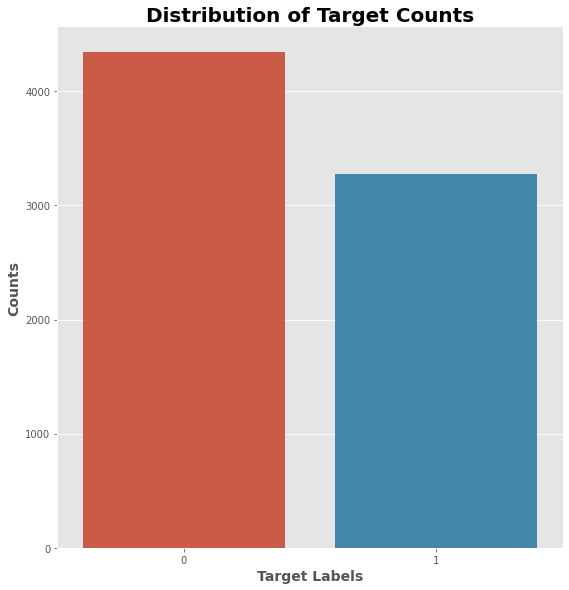

In [7]:
#visualizing the number of real and fake targets
sns.catplot("target", data=df, kind="count", height=8)
plt.title("Distribution of Target Counts", size=20, weight="bold")
plt.xlabel("Target Labels", size=14, weight="bold")
plt.ylabel("Counts", size=14, weight="bold")
plt.show()

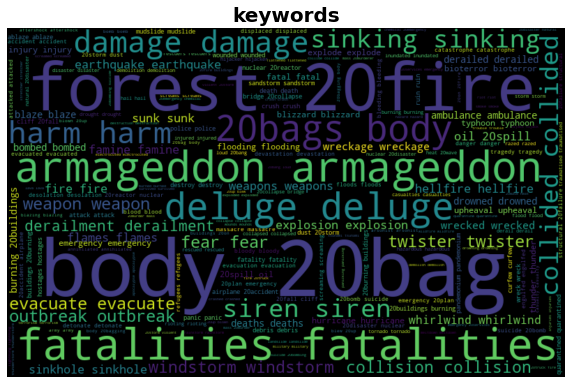

In [8]:
#generating the word cloud of the keywords
#getting all the words from keyword column
keywords = " ".join([keyword for keyword in df["keyword"].dropna()])
#generating the word cloud
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(keywords)
#visualization
plt.figure(figsize=(10, 8))
plt.title("keywords", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

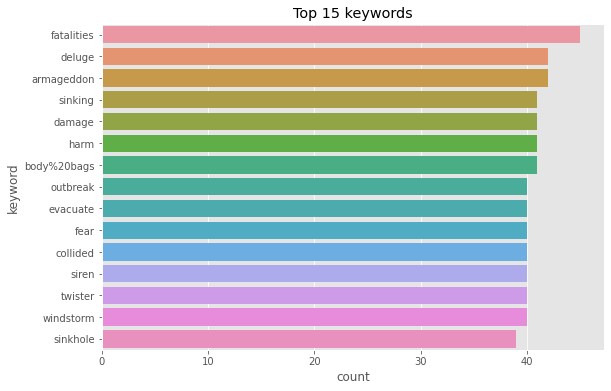

In [9]:
#visualizing the top keywords
plt.figure(figsize=(9,6))
sns.countplot(y=df.keyword, order = df.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()

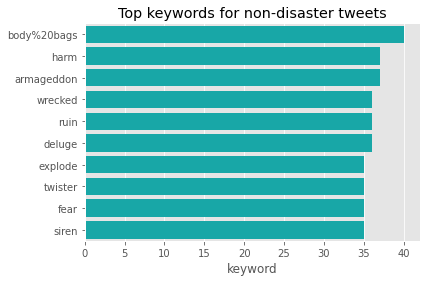

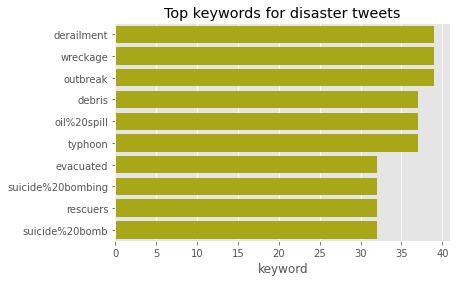

In [10]:
#top keywords comparison between fake and real tweets
kw_nd = df[df.target==0].keyword.value_counts().head(10)
sns.barplot(kw_nd, kw_nd.index, color='c')
plt.title('Top keywords for non-disaster tweets')
plt.show()
kw_d = df[df.target==1].keyword.value_counts().head(10)
sns.barplot(kw_d, kw_d.index, color='y')
plt.title('Top keywords for disaster tweets')
plt.show()

In [11]:
#a function for preprocessing the tweets
#by converting all text to lowercase,remove hyperlinks, hastags, punctuation, non-alphabetic characters, HTML tags and stopwords 
def preproc_tweet(tweet):
    #converting to lower case
    tweet = tweet.lower()
    #remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', str(tweet))
    #remove hashtags
    tweet = re.sub(r'#', '', str(tweet))
    #remove punctuation
    punct = set(string.punctuation)
    tweet = "".join(ch for ch in tweet if ch not in punct)
    #remove residual non-alphabetic characters 
    tweet = re.sub('[^A-Za-z]', ' ', str(tweet))
    #remove HTML tags
    html = re.compile(r'<.*?>')
    tweet = html.sub(r'', str(tweet))
    
    #remove stopwords
    stop_words = set(stopwords.words("english"))
    tweet = " ".join(word for word in tweet.split() if word not in stop_words)

    return tweet


In [12]:
#Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)



In [13]:
#preprocessing the tweets and save the results in a new column named preprocessed
#df= df.sample(frac=1, random_state=42).reset_index(drop=True)
df["preprocessed"]= df["text"].apply(preproc_tweet)
df["preprocessed"]= df["preprocessed"].apply(remove_emoji)
print(df["preprocessed"].head())
#print(df.head())

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
Name: preprocessed, dtype: object


In [14]:
#n-gram deployment
def generate_N_grams(text,ngram=1):
  words=[word for word in text.split(" ")]   # if word not in set(stopwords.words('english')) 
  #print("Sentence after removing stopwords:",words)
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

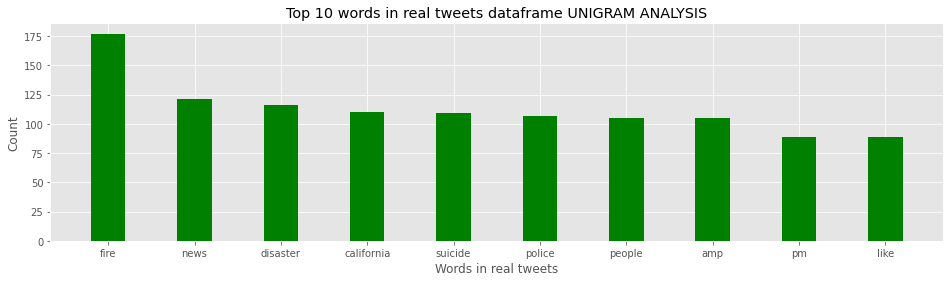

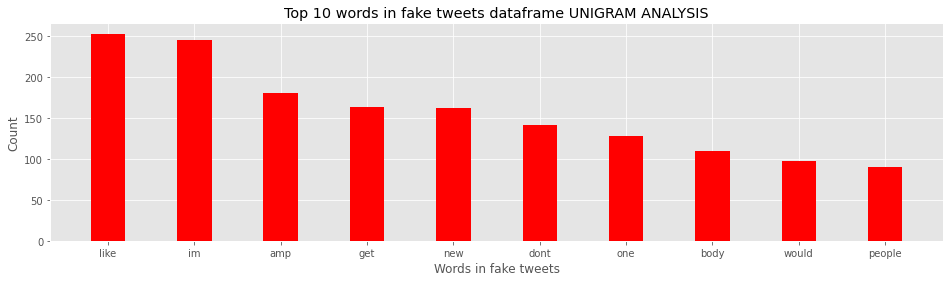

In [15]:
#unigram deployment

real_tweet=defaultdict(int)
fake_tweet=defaultdict(int)

#get the count of every word in both the columns of df_train and df_test dataframes
#real tweets
for text in df[df.target==1].preprocessed:
  for word in generate_N_grams(text):
    real_tweet[word]+=1

#fake tweets
for text in df[df.target==0].preprocessed:
  for word in generate_N_grams(text):
    fake_tweet[word]+=1

#focus on more frequently occuring words for every tweet
#sort in DO wrt 2nd column in each of real and fake tweets
df_real=pd.DataFrame(sorted(real_tweet.items(),key=lambda x:x[1],reverse=True))
df_fake=pd.DataFrame(sorted(fake_tweet.items(),key=lambda x:x[1],reverse=True))

reald1=df_real[0][:10]
reald2=df_real[1][:10]

faked1=df_fake[0][:10]
faked2=df_fake[1][:10]

plt.figure(1,figsize=(16,4))
plt.bar(reald1,reald2, color ='green',
        width = 0.4)
plt.xlabel("Words in real tweets")
plt.ylabel("Count")
plt.title("Top 10 words in real tweets dataframe UNIGRAM ANALYSIS")
plt.savefig("real_tweets.png")
plt.show()


plt.figure(1,figsize=(16,4))
plt.bar(faked1,faked2, color ='red',
        width = 0.4)
plt.xlabel("Words in fake tweets")
plt.ylabel("Count")
plt.title("Top 10 words in fake tweets dataframe UNIGRAM ANALYSIS")
plt.savefig("fake_tweets.png")
plt.show()


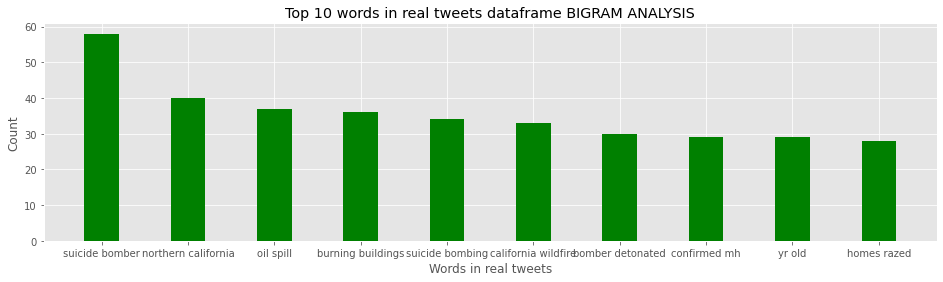

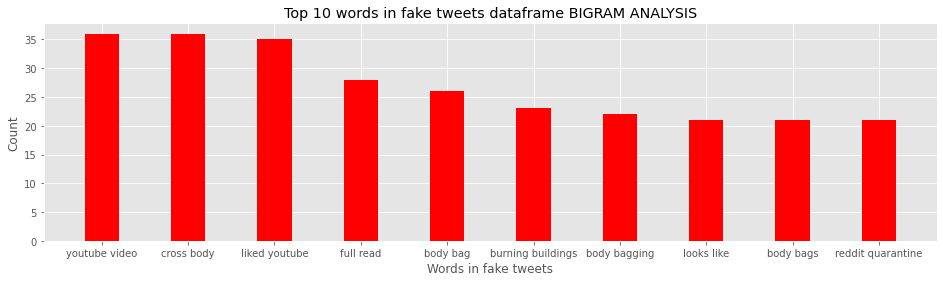

In [16]:
#bigram deployment
real_tweet2=defaultdict(int)
fake_tweet2=defaultdict(int)

#get the count of every word in both the columns of df_train and df_test dataframes
#real tweets
for text in df[df.target==1].preprocessed:
  for word in generate_N_grams(text,2):
    real_tweet2[word]+=1

#fake tweets
for text in df[df.target==0].preprocessed:
  for word in generate_N_grams(text,2):
    fake_tweet2[word]+=1

#focus on more frequently occuring words for every tweet
#sort in DO wrt 2nd column in each of real and fake tweets
df_real2=pd.DataFrame(sorted(real_tweet2.items(),key=lambda x:x[1],reverse=True))
df_fake2=pd.DataFrame(sorted(fake_tweet2.items(),key=lambda x:x[1],reverse=True))

reald12=df_real2[0][:10]
reald22=df_real2[1][:10]

faked12=df_fake2[0][:10]
faked22=df_fake2[1][:10]

plt.figure(1,figsize=(16,4))
plt.bar(reald12,reald22, color ='green',
        width = 0.4)
plt.xlabel("Words in real tweets")
plt.ylabel("Count")
plt.title("Top 10 words in real tweets dataframe BIGRAM ANALYSIS")
plt.savefig("real_tweets.png")
plt.show()


plt.figure(1,figsize=(16,4))
plt.bar(faked12,faked22, color ='red',
        width = 0.4)
plt.xlabel("Words in fake tweets")
plt.ylabel("Count")
plt.title("Top 10 words in fake tweets dataframe BIGRAM ANALYSIS")
plt.savefig("fake_tweets.png")
plt.show()


In [17]:
#preparing data for the models
#by tokenizing, lemmatizing, stemming, vectorizing using ngram method

#filling none values in keywords with None
df['keyword']=df['keyword'].fillna('None')
#filling none values in location with Unavailabe
df['location']=df['location'].fillna('Unavailable')

#Tokenization Process
tokenizer = TweetTokenizer()
tokens = [tokenizer.tokenize(word) for word in df['preprocessed']]
df = df.assign(tokens = tokens)
#print("after tokenization:\n",df.head())

#Lemmatization and stemming initialization 
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

#a function to turn tokens into lemmatized/stemmed strings
def lemmatize_stem_item(item):
    new_item = []
    for x in item:
        x = lemmatizer.lemmatize(x)
        x = stemmer.stem(x)
        new_item.append(x)
    return " ".join(new_item)

#lemmatize and stem the tweets
#check by the stemmed flag
if not 'stemmed' in df:
    df.tokens = [lemmatize_stem_item(item) for item in df.tokens]
    df['stemmed'] = True
#print("after lemmatization and stemming:\n",df.head())


#defining independant value
X=df[["tokens", "keyword", "location"]]
#defining the target as dependant value
y=df["target"]
#split the dataframe into train and test sets
#X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.30)
#print("X_train:\n",X_train.head())



#Vectorization process
#building vector based on tokens
#initializing the vector
vectorizer = CountVectorizer()
#building the train vector
#train_vectors = vectorizer.fit_transform(X.tokens)
#print(vectorizer.get_feature_names_out())
#building vector based on n-grams
#initializing the vector based on unigrams and bigrams
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(1, 2))
#building the train vector
X2 = vectorizer.fit_transform(X.tokens)
print(vectorizer.get_feature_names_out())


X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.30, random_state = 42)
#print("after vectorization:\n",train_x_vectors)
print('Number of rows in training set: ' , X_train.shape[0])
print('Number of rows in test set: ' , X_test.shape[0])
#print('Number of rows in X: ' , X.shape)
#print('Number of rows in X2: ' , X2.shape)


['aa' 'aaaa' 'aaaaaaallll' ... 'zurich' 'zxatheti' 'zzzz']
Number of rows in training set:  5329
Number of rows in test set:  2284


Support Vector Classifier:

accuracy: 80.69
precision: 86.51
recall: 64.39
F1 measure: 0.801
ROC AUC: 78.51
confusion matrix:
 [[1221   97]
 [ 344  622]]


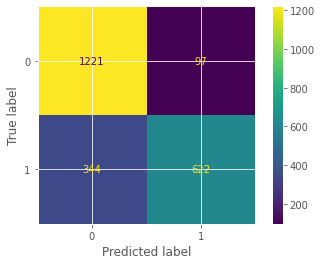

In [18]:
#deploying SVC
#build and fit the SVC model
SVC_classifier = SVC(probability = True, random_state = 42).fit(X_train, y_train)
#predict based on the classifier
y_pred_SVC = SVC_classifier.predict(X_test)
#measuring evaluating metrics
print("Support Vector Classifier:\n")
#print('Classification report:', classification_report(y_test, y_pred_SVC))
print("accuracy:",round((accuracy_score(y_test, y_pred_SVC)*100),2))
print("precision:",round((precision_score(y_test, y_pred_SVC)*100),2))
print("recall:",round((recall_score(y_test, y_pred_SVC)*100),2))
print("F1 measure:",round(f1_score(y_test, y_pred_SVC, average='weighted'), 3))
print("ROC AUC:",round((roc_auc_score(y_test, y_pred_SVC)*100),2))
print("confusion matrix:\n",confusion_matrix(y_test,y_pred_SVC))
plot_confusion_matrix(SVC_classifier, X_test, y_test) 
plt.show()



random forest classifier:

accuracy: 60.6
precision: 100.0
recall: 6.83
F1 measure: 0.484
ROC AUC: 53.42
confusion matrix:
 [[1318    0]
 [ 900   66]]


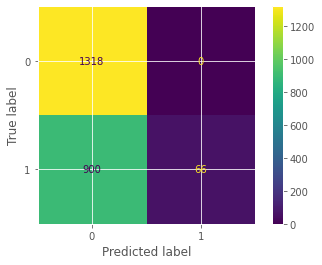

In [19]:
#deploying random forest
#build the random forest classifier
random_forest_clf = RandomForestClassifier(max_depth=5, random_state=0)
#fit the classifier
random_forest_clf.fit(X_train, y_train)
#predict based on the classifier
y_pred_random_forest=random_forest_clf.predict(X_test)
#measuring evaluating metrics
print("random forest classifier:\n")
print("accuracy:",round((accuracy_score(y_test, y_pred_random_forest)*100),2))
print("precision:",round((precision_score(y_test, y_pred_random_forest)*100),2))
print("recall:",round((recall_score(y_test, y_pred_random_forest)*100),2))
print("F1 measure:",round(f1_score(y_test, y_pred_random_forest, average='weighted'), 3))
print("ROC AUC:",round((roc_auc_score(y_test, y_pred_random_forest)*100),2))
print("confusion matrix:\n",confusion_matrix(y_test,y_pred_random_forest))
plot_confusion_matrix(random_forest_clf, X_test, y_test) 
plt.show()


In [20]:
#preparing data for the models
#by tokenizing, lemmatizing, stemming, vectorizing using ngram method

#defining independant value
X=df["preprocessed"]
#defining the target as dependant value
y=df["target"]

#split the dataframe into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)
#print("X_train:\n",X_train.head())
print('Number of rows in training set: ' , X_train.shape[0])
print('Number of rows in test set: ' , X_test.shape[0])


#Tokenization Process

#initializing the tokenizer hyperparameters
vocab_size= 5000
oov_token= '<UNK>'
pad_type= 'post'
trunc_type= 'post'
max_length=25


#initialize the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
#initialize the Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

#train set

#Tokenize tweets
tokenizer.fit_on_texts(X_train)
# Get our training data word index
word_index = tokenizer.word_index
#lemmatize tweet's tokens 
for w in word_index:
  lemmatizer.lemmatize(w) 
print("X_train: ",X_train.head())

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
#print("train sequence: ",train_sequences)

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=max_length)
#print("train padded: ",train_padded)
print("X_train: ",X_train.head())


#test set

tokenizer.fit_on_texts(X_test)
#print("X_test: ",X_test.head())
word_index = tokenizer.word_index
#print("test word index: ",word_index)
for w in word_index:
  lemmatizer.lemmatize(w) 
  #print("test lemmatized: ",w)
test_sequences = tokenizer.texts_to_sequences(X_test)
#print("test sequences: ",test_sequences)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=max_length)
#print("test padded: ",test_padded)


Number of rows in training set:  5329
Number of rows in test set:  2284
X_train:  1186    ashes australia collapse trent bridge among wo...
4071    great michigan technique camp b g thanks bmurp...
5461    cnn tennessee movie theater shooting suspect k...
5787                still rioting couple hours left class
7445    crack path wiped morning beach run surface wou...
Name: preprocessed, dtype: object
X_train:  1186    ashes australia collapse trent bridge among wo...
4071    great michigan technique camp b g thanks bmurp...
5461    cnn tennessee movie theater shooting suspect k...
5787                still rioting couple hours left class
7445    crack path wiped morning beach run surface wou...
Name: preprocessed, dtype: object


In [21]:
#The LSTM Model
#initializing the variables
max_length=25
vocab_size=60000
embedding_dim=12
#building the model
LSTM_model1=keras.models.Sequential([ 
    keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    keras.layers.Dropout(0.2),
    keras.layers.Bidirectional(keras.layers.LSTM(72)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')])
print(LSTM_model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 12)            720000    
                                                                 
 dropout (Dropout)           (None, 25, 12)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 144)              48960     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                3480      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 772,465
Trainable params: 772,465
Non-trainable params: 0
__________________________________________________

In [22]:
#compile the model
LSTM_model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#fit the model
history=LSTM_model1.fit(train_padded,y_train, validation_data=(test_padded,y_test), epochs=10,batch_size=64)

Epoch 1/10
84/84 [==============================] - 9s 55ms/step - loss: 0.6339 - accuracy: 0.6373 - val_loss: 0.7439 - val_accuracy: 0.5823
Epoch 2/10
84/84 [==============================] - 4s 43ms/step - loss: 0.4002 - accuracy: 0.8337 - val_loss: 0.8502 - val_accuracy: 0.5582
Epoch 3/10
84/84 [==============================] - 4s 44ms/step - loss: 0.3097 - accuracy: 0.8741 - val_loss: 1.1510 - val_accuracy: 0.5315
Epoch 4/10
84/84 [==============================] - 4s 43ms/step - loss: 0.2629 - accuracy: 0.8989 - val_loss: 1.1815 - val_accuracy: 0.5293
Epoch 5/10
84/84 [==============================] - 4s 43ms/step - loss: 0.2276 - accuracy: 0.9139 - val_loss: 1.4151 - val_accuracy: 0.5162
Epoch 6/10
84/84 [==============================] - 4s 43ms/step - loss: 0.2070 - accuracy: 0.9172 - val_loss: 1.6076 - val_accuracy: 0.5236
Epoch 7/10
84/84 [==============================] - 4s 44ms/step - loss: 0.1774 - accuracy: 0.9309 - val_loss: 1.6027 - val_accuracy: 0.5079
Epoch 8/10
84

72/72 [==============================] - 1s 7ms/step - loss: 2.1158 - accuracy: 0.5053
[2.115841865539551, 0.5052539110183716]


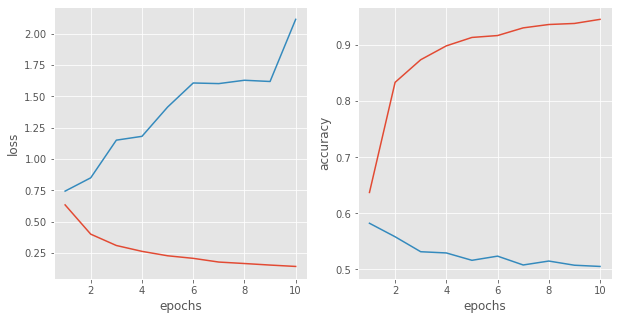

In [23]:
#visualizing the results of the LSTM model
%matplotlib inline
import matplotlib.pyplot as plt
#plotting the loss and the accuracy based on epochs
plt.figure(figsize=(10,5))
def plots(n,kind):
    ax1=plt.subplot(1,2,n)
    x_val=np.arange(1,11)
    ax1.plot(x_val,history.history[kind])
    ax1.plot(x_val,history.history['val_'+kind])
    ax1.set(xlabel='epochs')
    ax1.set(ylabel=kind)
    
plots(n=1,kind='loss')
plots(n=2,kind='accuracy')


print(LSTM_model1.evaluate(test_padded,y_test))

In [24]:
#predicting using the LSTM model
y_pred_LSTM_model1 = (LSTM_model1.predict(test_padded) > 0.5).astype("int32")
#print(y_pred_LSTM_model1)
#np.unique(y_pred_LSTM_model1,axis=0)
#printing the accuracy metrics
print("LSTM_model1: optimizer: adam, epochs: 10, batchsize: 64\n")
print("accuracy:",round((accuracy_score(y_test, y_pred_LSTM_model1)*100),2))
print("precision:",round((precision_score(y_test, y_pred_LSTM_model1)*100),2))
print("recall:",round((recall_score(y_test, y_pred_LSTM_model1)*100),2))
print("F1measure:",round(f1_score(y_test, y_pred_LSTM_model1, average='weighted'), 3))
print("ROC AUC:",round((roc_auc_score(y_test, y_pred_LSTM_model1)*100),2))
print("confusion matrix:\n",confusion_matrix(y_test,y_pred_LSTM_model1))


LSTM_model1: optimizer: adam, epochs: 10, batchsize: 64

accuracy: 50.53
precision: 42.45
recall: 47.72
F1measure: 0.508
ROC AUC: 50.15
confusion matrix:
 [[693 625]
 [505 461]]


Epoch 1/10
167/167 [==============================] - 12s 43ms/step - loss: 0.1598 - accuracy: 0.9362 - val_loss: 1.4536 - val_accuracy: 0.5223
Epoch 2/10
167/167 [==============================] - 6s 35ms/step - loss: 0.1350 - accuracy: 0.9454 - val_loss: 1.8042 - val_accuracy: 0.5140
Epoch 3/10
167/167 [==============================] - 6s 35ms/step - loss: 0.1185 - accuracy: 0.9518 - val_loss: 2.3136 - val_accuracy: 0.5018
Epoch 4/10
167/167 [==============================] - 6s 35ms/step - loss: 0.1134 - accuracy: 0.9501 - val_loss: 2.2033 - val_accuracy: 0.5293
Epoch 5/10
167/167 [==============================] - 6s 36ms/step - loss: 0.1073 - accuracy: 0.9527 - val_loss: 2.9109 - val_accuracy: 0.5066
Epoch 6/10
167/167 [==============================] - 6s 35ms/step - loss: 0.0960 - accuracy: 0.9576 - val_loss: 2.4800 - val_accuracy: 0.5180
Epoch 7/10
167/167 [==============================] - 6s 35ms/step - loss: 0.0972 - accuracy: 0.9563 - val_loss: 3.5678 - val_accuracy: 0.502

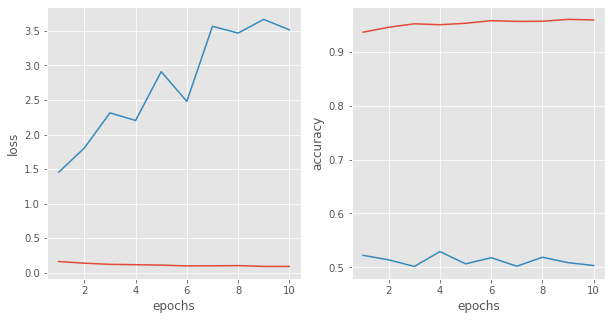

In [25]:

#LSTM_model1: optimizer: adam, epochs: 10, batchsize: 32

#compile the model
LSTM_model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#fit the model
history=LSTM_model1.fit(train_padded,y_train, validation_data=(test_padded,y_test), epochs=10,batch_size=32)

#plotting the loss and the accuracy based on epochs
plt.figure(figsize=(10,5))
def plots(n,kind):
    ax1=plt.subplot(1,2,n)
    x_val=np.arange(1,11)
    ax1.plot(x_val,history.history[kind])
    ax1.plot(x_val,history.history['val_'+kind])
    ax1.set(xlabel='epochs')
    ax1.set(ylabel=kind)
    
plots(n=1,kind='loss')
plots(n=2,kind='accuracy')

#predicting using the LSTM model
y_pred_LSTM_model1 = (LSTM_model1.predict(test_padded) > 0.5).astype("int32")
#print(y_pred_LSTM_model1)
#np.unique(y_pred_LSTM_model1,axis=0)
#printing the accuracy metrics
print("LSTM_model1: optimizer: adam, epochs: 10, batchsize: 32\n")
print("accuracy:",round((accuracy_score(y_test, y_pred_LSTM_model1)*100),2))
print("precision:",round((precision_score(y_test, y_pred_LSTM_model1)*100),2))
print("recall:",round((recall_score(y_test, y_pred_LSTM_model1)*100),2))
print("F1measure:",round(f1_score(y_test, y_pred_LSTM_model1, average='weighted'), 3))
print("ROC AUC:",round((roc_auc_score(y_test, y_pred_LSTM_model1)*100),2))
print("confusion matrix:\n",confusion_matrix(y_test,y_pred_LSTM_model1))

Epoch 1/10
334/334 [==============================] - 15s 33ms/step - loss: 0.1181 - accuracy: 0.9493 - val_loss: 2.3097 - val_accuracy: 0.5219
Epoch 2/10
334/334 [==============================] - 12s 36ms/step - loss: 0.0996 - accuracy: 0.9557 - val_loss: 2.6526 - val_accuracy: 0.4934
Epoch 3/10
334/334 [==============================] - 10s 30ms/step - loss: 0.0877 - accuracy: 0.9580 - val_loss: 2.7488 - val_accuracy: 0.5127
Epoch 4/10
334/334 [==============================] - 10s 30ms/step - loss: 0.0818 - accuracy: 0.9621 - val_loss: 3.6284 - val_accuracy: 0.4987
Epoch 5/10
334/334 [==============================] - 10s 30ms/step - loss: 0.0856 - accuracy: 0.9589 - val_loss: 2.8187 - val_accuracy: 0.5057
Epoch 6/10
334/334 [==============================] - 10s 30ms/step - loss: 0.0818 - accuracy: 0.9612 - val_loss: 2.9035 - val_accuracy: 0.5180
Epoch 7/10
334/334 [==============================] - 10s 30ms/step - loss: 0.0788 - accuracy: 0.9642 - val_loss: 3.0320 - val_accuracy:

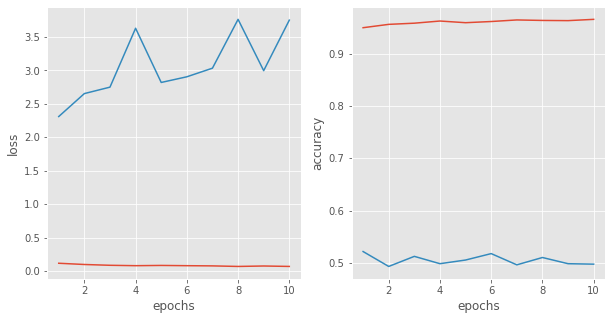

In [26]:

#LSTM_model1: optimizer: adam, epochs: 10, batchsize: 16

#compile the model
LSTM_model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#fit the model
history=LSTM_model1.fit(train_padded,y_train, validation_data=(test_padded,y_test), epochs=10,batch_size=16)

#plotting the loss and the accuracy based on epochs
plt.figure(figsize=(10,5))
def plots(n,kind):
    ax1=plt.subplot(1,2,n)
    x_val=np.arange(1,11)
    ax1.plot(x_val,history.history[kind])
    ax1.plot(x_val,history.history['val_'+kind])
    ax1.set(xlabel='epochs')
    ax1.set(ylabel=kind)
    
plots(n=1,kind='loss')
plots(n=2,kind='accuracy')

#predicting using the LSTM model
y_pred_LSTM_model1 = (LSTM_model1.predict(test_padded) > 0.5).astype("int32")
#print(y_pred_LSTM_model1)
#np.unique(y_pred_LSTM_model1,axis=0)
#printing the accuracy metrics
print("LSTM_model1: optimizer: adam, epochs: 10, batchsize: 16\n")
print("accuracy:",round((accuracy_score(y_test, y_pred_LSTM_model1)*100),2))
print("precision:",round((precision_score(y_test, y_pred_LSTM_model1)*100),2))
print("recall:",round((recall_score(y_test, y_pred_LSTM_model1)*100),2))
print("F1measure:",round(f1_score(y_test, y_pred_LSTM_model1, average='weighted'), 3))
print("ROC AUC:",round((roc_auc_score(y_test, y_pred_LSTM_model1)*100),2))
print("confusion matrix:\n",confusion_matrix(y_test,y_pred_LSTM_model1))

In [29]:

#LSTM_model1: optimizer: adam, epochs: 20, batchsize: 16

#compile the model
LSTM_model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#fit the model
history=LSTM_model1.fit(train_padded,y_train, validation_data=(test_padded,y_test), epochs=20,batch_size=16)

#predicting using the LSTM model
y_pred_LSTM_model1 = (LSTM_model1.predict(test_padded) > 0.5).astype("int32")
#print(y_pred_LSTM_model1)
#np.unique(y_pred_LSTM_model1,axis=0)
#printing the accuracy metrics
print("LSTM_model1: optimizer: adam, epochs: 20, batchsize: 16\n")
print("accuracy:",round((accuracy_score(y_test, y_pred_LSTM_model1)*100),2))
print("precision:",round((precision_score(y_test, y_pred_LSTM_model1)*100),2))
print("recall:",round((recall_score(y_test, y_pred_LSTM_model1)*100),2))
print("F1measure:",round(f1_score(y_test, y_pred_LSTM_model1, average='weighted'), 3))
print("ROC AUC:",round((roc_auc_score(y_test, y_pred_LSTM_model1)*100),2))
print("confusion matrix:\n",confusion_matrix(y_test,y_pred_LSTM_model1))

Epoch 1/20
334/334 [==============================] - 17s 41ms/step - loss: 0.0503 - accuracy: 0.9737 - val_loss: 4.2926 - val_accuracy: 0.5018
Epoch 2/20
334/334 [==============================] - 18s 55ms/step - loss: 0.0483 - accuracy: 0.9705 - val_loss: 4.0775 - val_accuracy: 0.5114
Epoch 3/20
334/334 [==============================] - 20s 61ms/step - loss: 0.0480 - accuracy: 0.9730 - val_loss: 4.6261 - val_accuracy: 0.5009
Epoch 4/20
334/334 [==============================] - 13s 38ms/step - loss: 0.0469 - accuracy: 0.9756 - val_loss: 4.4422 - val_accuracy: 0.5022
Epoch 5/20
334/334 [==============================] - 9s 28ms/step - loss: 0.0448 - accuracy: 0.9762 - val_loss: 4.5703 - val_accuracy: 0.5066
Epoch 6/20
334/334 [==============================] - 9s 28ms/step - loss: 0.0492 - accuracy: 0.9747 - val_loss: 4.1345 - val_accuracy: 0.5022
Epoch 7/20
334/334 [==============================] - 9s 28ms/step - loss: 0.0433 - accuracy: 0.9758 - val_loss: 4.6007 - val_accuracy: 0.

In [30]:

#LSTM_model1: optimizer: adam, epochs: 20, batchsize: 32

#compile the model
LSTM_model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#fit the model
history=LSTM_model1.fit(train_padded,y_train, validation_data=(test_padded,y_test), epochs=20,batch_size=32)

#predicting using the LSTM model
y_pred_LSTM_model1 = (LSTM_model1.predict(test_padded) > 0.5).astype("int32")
#print(y_pred_LSTM_model1)
#np.unique(y_pred_LSTM_model1,axis=0)
#printing the accuracy metrics
print("LSTM_model1: optimizer: adam, epochs: 20, batchsize: 32\n")
print("accuracy:",round((accuracy_score(y_test, y_pred_LSTM_model1)*100),2))
print("precision:",round((precision_score(y_test, y_pred_LSTM_model1)*100),2))
print("recall:",round((recall_score(y_test, y_pred_LSTM_model1)*100),2))
print("F1measure:",round(f1_score(y_test, y_pred_LSTM_model1, average='weighted'), 3))
print("ROC AUC:",round((roc_auc_score(y_test, y_pred_LSTM_model1)*100),2))
print("confusion matrix:\n",confusion_matrix(y_test,y_pred_LSTM_model1))

Epoch 1/20
167/167 [==============================] - 10s 38ms/step - loss: 0.0429 - accuracy: 0.9764 - val_loss: 5.2893 - val_accuracy: 0.4899
Epoch 2/20
167/167 [==============================] - 5s 33ms/step - loss: 0.0458 - accuracy: 0.9756 - val_loss: 4.4250 - val_accuracy: 0.4961
Epoch 3/20
167/167 [==============================] - 5s 32ms/step - loss: 0.0418 - accuracy: 0.9765 - val_loss: 4.9728 - val_accuracy: 0.4965
Epoch 4/20
167/167 [==============================] - 5s 32ms/step - loss: 0.0413 - accuracy: 0.9775 - val_loss: 4.8160 - val_accuracy: 0.5004
Epoch 5/20
167/167 [==============================] - 6s 33ms/step - loss: 0.0419 - accuracy: 0.9762 - val_loss: 5.1921 - val_accuracy: 0.4926
Epoch 6/20
167/167 [==============================] - 5s 33ms/step - loss: 0.0436 - accuracy: 0.9771 - val_loss: 5.1101 - val_accuracy: 0.4974
Epoch 7/20
167/167 [==============================] - 5s 32ms/step - loss: 0.0430 - accuracy: 0.9769 - val_loss: 4.6086 - val_accuracy: 0.501

In [31]:

#LSTM_model1: optimizer: adam, epochs: 20, batchsize: 64

#compile the model
LSTM_model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#fit the model
history=LSTM_model1.fit(train_padded,y_train, validation_data=(test_padded,y_test), epochs=20,batch_size=64)

#predicting using the LSTM model
y_pred_LSTM_model1 = (LSTM_model1.predict(test_padded) > 0.5).astype("int32")
#print(y_pred_LSTM_model1)
#np.unique(y_pred_LSTM_model1,axis=0)
#printing the accuracy metrics
print("LSTM_model1: optimizer: adam, epochs: 20, batchsize: 64\n")
print("accuracy:",round((accuracy_score(y_test, y_pred_LSTM_model1)*100),2))
print("precision:",round((precision_score(y_test, y_pred_LSTM_model1)*100),2))
print("recall:",round((recall_score(y_test, y_pred_LSTM_model1)*100),2))
print("F1measure:",round(f1_score(y_test, y_pred_LSTM_model1, average='weighted'), 3))
print("ROC AUC:",round((roc_auc_score(y_test, y_pred_LSTM_model1)*100),2))
print("confusion matrix:\n",confusion_matrix(y_test,y_pred_LSTM_model1))

Epoch 1/20
84/84 [==============================] - 8s 51ms/step - loss: 0.0391 - accuracy: 0.9782 - val_loss: 5.2497 - val_accuracy: 0.4987
Epoch 2/20
84/84 [==============================] - 3s 40ms/step - loss: 0.0396 - accuracy: 0.9769 - val_loss: 5.4378 - val_accuracy: 0.4912
Epoch 3/20
84/84 [==============================] - 3s 40ms/step - loss: 0.0399 - accuracy: 0.9775 - val_loss: 5.0954 - val_accuracy: 0.5057
Epoch 4/20
84/84 [==============================] - 3s 41ms/step - loss: 0.0412 - accuracy: 0.9769 - val_loss: 5.1469 - val_accuracy: 0.5039
Epoch 5/20
84/84 [==============================] - 4s 43ms/step - loss: 0.0405 - accuracy: 0.9777 - val_loss: 5.1185 - val_accuracy: 0.5013
Epoch 6/20
84/84 [==============================] - 4s 43ms/step - loss: 0.0400 - accuracy: 0.9780 - val_loss: 4.8870 - val_accuracy: 0.5070
Epoch 7/20
84/84 [==============================] - 3s 41ms/step - loss: 0.0411 - accuracy: 0.9769 - val_loss: 4.5528 - val_accuracy: 0.5000
Epoch 8/20
84

In [25]:
#lstm hyperparameter tuning

In [ ]:
def create_model(optimizer = 'adam'):
  max_length=25
  vocab_size=60000
  embedding_dim=12
  LSTM_model=keras.models.Sequential([ 
    keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    keras.layers.Dropout(0.2),
    keras.layers.Bidirectional(keras.layers.LSTM(72)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')])
  LSTM_model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return LSTM_model


#neurons = [1, 2, 3, 4, 5]

optimizers = ['rmsprop','SGD','adam']
batches = [4,8,16]
epochs=[25,50]
param_grid = dict(batch_size=batches, optimizer=optimizers, epochs=epochs)
hp_model = KerasClassifier(build_fn=create_model, verbose=0)
grid=GridSearchCV(estimator = hp_model, param_grid = param_grid)
grid_result = grid.fit(train_padded, y_train)
print(grid_result.best_score_)

In [ ]:


'''
    input_seq = Input(shape=(13,))
    hidden_1 = Dense(29, activation = 'tanh')(input_seq)
    hidden_2 = Dense(24, activation = 'tanh')(hidden_1)
    hidden_3 = Dense(19, activation = 'tanh')(hidden_2)
    output_seq = Dense(1, activation= 'sigmoid')(hidden_3)
    model_class = Model(input_seq,output_seq)
    model_class.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])

'''

# Build the model
print('Build model...')
model = Sequential()
model.add(LSTM(hidden_nodes, return_sequences=False, input_shape=(word_vec_length, char_vec_length)))
model.add(Dropout(0.2))
model.add(Dense(units=output_labels))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

batch_size=1000
model.fit(train_x, train_y, batch_size=batch_size, epochs=10, validation_data=(validate_x, validate_y))

validate['predicted_gender'] = ['m' if prediction[0] > prediction[1] else 'f' for prediction in model.predict(validate_x)]
validate[validate['gender'] != validate['predicted_gender']].head()



# Create function
def nn_cl_bo(neurons, activation, optimizer, learning_rate,  batch_size, epochs ):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    batch_size = round(batch_size)
    epochs = round(epochs)
    def nn_cl_fun():
        opt = Adam(lr = learning_rate)
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=10, activation=activation))
        nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size,
                         verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score



    # Set paramaters
params_nn ={
    'neurons': (10, 100),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)


params_nn_ = nn_bo.max['params']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_

In [ ]:
def build_model(hp):          #hp means hyper parameters
    model=Sequential()
    model.add(Flatten(input_shape=(28,28)))
    #providing range for number of neurons in a hidden layer
    model.add(Dense(units=hp.Int('num_of_neurons',min_value=32,max_value=512,step=32),
                                    activation='relu'))
    #output layer
    model.add(Dense(10,activation='softmax'))
    #compiling the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model


#feeding the model and parameters to Random Search
tuner=RandomSearch(build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='tuner1',
    project_name='Clothing')

#this tells us how many hyperparameter we are tuning
#in our case it's 2 = neurons,learning rate
tuner.search_space_summary()

#fitting the tuner on train dataset
tuner.search(X_train,y_train,epochs=10,validation_data=(X_test,y_test))

tuner.results_summary()

In [ ]:
epochs = [500, 1000, 2000, 4000, 6000]
batches = [1, 2, 4]
neurons = [1, 2, 3, 4, 5]



optimizers = ['rmsprop', 'SGD','adam']
batches = [5,10,15]
epochs=[50]
param_grid = dict(batch_size=batches, optimizer=optimizers, epochs=epochs)
hp_model = KerasClassifier(build_fn=create_model, verbose=0)
grid=GridSearchCV(estimator = hp_model, param_grid = param_grid)
grid_result = grid.fit(X_train_scaled, y_train_class)
print(grid_result.best_score_)

In [ ]:
#predicting using the LSTM model
y_pred_LSTM_model1 = (LSTM_model1.predict(test_padded) > 0.5).astype("int32")
#print(y_pred_LSTM_model1)
#np.unique(y_pred_LSTM_model1,axis=0)
#printing the accuracy metrics
print("LSTM_model1:\n")
print("accuracy:",round((accuracy_score(y_test, y_pred_LSTM_model1)*100),2))
print("precision:",round((precision_score(y_test, y_pred_LSTM_model1)*100),2))
print("recall:",round((recall_score(y_test, y_pred_LSTM_model1)*100),2))
print("F1measure:",round(f1_score(y_test, y_pred_LSTM_model1, average='weighted'), 3))
print("ROC AUC:",round((roc_auc_score(y_test, y_pred_LSTM_model1)*100),2))
print("confusion matrix:\n",confusion_matrix(y_test,y_pred_LSTM_model1))


In [ ]:
#preprosessing for the linera classifier and random forest
#filling none values in keywords with None
df['keyword']=df['keyword'].fillna('None')
#filling none values in location with Unavailabe
df['location']=df['location'].fillna('Unavailable')

#Tokenization Process
#tokenizer = word_tokenize()
#tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_token)
#tokens = [word_tokenize(df['preprocessed']).tokenize(word) for word in df['preprocessed']]
tokenizer = TweetTokenizer()
tokens = [tokenizer.tokenize(word) for word in df['preprocessed']]
df = df.assign(tokens = tokens)

print("after tokenization:\n",df.head())

#Lemmatization Process
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Turn tokens into lemmatized/stemmed strings
def lemmatize_stem_item(item):
    new_item = []
    for x in item:
        x = lemmatizer.lemmatize(x)
        x = stemmer.stem(x)
        new_item.append(x)
    return " ".join(new_item)

#if the tweets are not steemed then this if statement filters that help complete the stemming process
if not 'stemmed' in df:
    df.tokens = [lemmatize_stem_item(item) for item in df.tokens]
    df['stemmed'] = True

print("after lemmatization and stemming:\n",df.head())

#Vectorization process
vectorizer = CountVectorizer()
print("tokens:\n",df.tokens)

train_x_vectors = vectorizer.fit_transform(df.tokens)
print("after vectorization:\n",train_x_vectors)

X=train_x_vectors
y=df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)
print('Number of rows in training set: ' + str(X_train.shape))
print('Number of rows in test set: ' + str(X_test.shape))





In [ ]:
#deploying linear classifier
#build and fit classifier
LR_clf = LogisticRegression(random_state = 42, solver = 'liblinear').fit(X_train, y_train)
#predict based on the model
y_pred_LR = LR_clf.predict(X_test)
#print('The first two predicted labels:', y_pred_LR[0], y_pred_LR[1], '\n')
#measuring evaluating metrics 
print("linear classifier:\n")
print('Classification report:\n', classification_report(y_test, y_pred_LR))
print("accuracy:",round((accuracy_score(y_test, y_pred_LR)*100),2))
print("precision:",round((precision_score(y_test, y_pred_LR)*100),2))
print("recall:",round((recall_score(y_test, y_pred_LR)*100),2))
print("F1 measure:",round(f1_score(y_test, y_pred_LR, average='weighted'), 3))
print("ROC AUC:",round((roc_auc_score(y_test, y_pred_LR)*100),2))
print("confusion matrix:\n",confusion_matrix(y_test,y_pred_LR))
plot_confusion_matrix(LR_clf, X_test, y_test) 
plt.show()



In [ ]:
#deploying SVC
#build and fit the SVC model
SVC_classifier = SVC(probability = True, random_state = 42).fit(X_train, y_train)
#predict based on the classifier
y_pred_SVC = SVC_classifier.predict(X_test)
#measuring evaluating metrics
print("SVC:\n")
print('Classification report:', classification_report(y_test, y_pred_SVC))
print("accuracy:",round((accuracy_score(y_test, y_pred_SVC)*100),2))
print("precision:",round((precision_score(y_test, y_pred_SVC)*100),2))
print("recall:",round((recall_score(y_test, y_pred_SVC)*100),2))
print("F1 measure:",round(f1_score(y_test, y_pred_SVC, average='weighted'), 3))
print("ROC AUC:",round((roc_auc_score(y_test, y_pred_SVC)*100),2))
print("confusion matrix:\n",confusion_matrix(y_test,y_pred_SVC))
plot_confusion_matrix(SVC_classifier, X_test, y_test) 
plt.show()


In [ ]:
#deploying random forest
#build the random forest classifier
random_forest_clf = RandomForestClassifier(max_depth=5, random_state=0)
#fit the classifier
random_forest_clf.fit(X_train, y_train)
#predict based on the classifier
y_pred_random_forest=random_forest_clf.predict(X_test)
#measuring evaluating metrics
print("random forest classifier:\n")
print("accuracy:",round((accuracy_score(y_test, y_pred_random_forest)*100),2))
print("precision:",round((precision_score(y_test, y_pred_random_forest)*100),2))
print("recall:",round((recall_score(y_test, y_pred_random_forest)*100),2))
print("F1 measure:",round(f1_score(y_test, y_pred_random_forest, average='weighted'), 3))
print("ROC AUC:",round((roc_auc_score(y_test, y_pred_random_forest)*100),2))
print("confusion matrix:\n",confusion_matrix(y_test,y_pred_random_forest))
plot_confusion_matrix(random_forest_clf, X_test, y_test) 
plt.show()



In [ ]:
##########################################
## correct spelling using pyspellchecker
!pip install pyspellchecker
from spellchecker import SpellChecker
def correct_spellings(text):
    corrected_text = []
    misspelled_words = SpellChecker().unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(SpellChecker().correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
text = "corect me plese"

In [ ]:
#a function for converting the words of the tweets to their base form
def base_form_tweet(tweet):
    #initialize the Wordnet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    #tokenize, Split the tweet into words
    word_list = nltk.word_tokenize(tweet)
    #print(len(word_list))
    #lemmatize tweet's tokens and join
    lemmatized_tweet = ' '.join([lemmatizer.lemmatize(w) for w in word_list])  
    return lemmatized_tweet




    # Lemmatization
    #from nltk.stem import WordNetLemmatizer
    #wordnet_lemmatizer = WordNetLemmatizer()
    #def lemmatize(text):
    #lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    #return " ".join(lemmatized_word)

In [ ]:
#tokenize and lemmatize the preprocessed tweets
#and save the results in a new column named base_form
df["base_form"]= df["preprocessed"]
for tweet in df["base_form"]:
  tweet=base_form_tweet(tweet)
#df["base_form"]= df["preprocessed"].apply(base_form_tweet)
print(df["base_form"].head())

In [ ]:
#a function for padding
def padding_tweet(tweet,max_length):
    #padding is for preprocessing in neural networks
    padded_tweet=pad_sequences(tweet,padding='post',maxlen=max_length,truncating='post') 
    return padded_tweet


#embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)

#train_sequence=tokenizer.texts_to_sequences(X_train)
#train_padseq=pad_sequences(train_sequence,padding='post',maxlen=max_length,truncating=trunc_type) #pad_sequnce is just for preprocessing in neural nets

#test_sequence=tokenizer.texts_to_sequences(X_test)
#test_padseq=pad_sequences(test_sequence,padding='post',truncating=trunc_type) #pad_sequnce is just for preprocessing in neural nets
#l=test_sequence[16]
#tokenizer.sequences_to_texts([l])



In [ ]:
#padding the tweets to make them ready for the neural network
#and save the results in a new column named padded
#defining max length
max_length = 25
#embedding_dim = 16
df["padded"]= df["base_form"]
for tweet in df["base_form"]:
  tweet=padding_tweet(tweet,max_length)
#df["base_form"]= df["preprocessed"].apply(base_form_tweet)
print(df["base_form"].head())    


In [ ]:
## Creating model
embedding_vector_features=50
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100))) ##Just add bidirectional!!, except it would just behave as normal LSTM Model
# model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

In [ ]:
## Creating model
embedding_vector_features=50
model2=Sequential()
model2.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model2.add(Bidirectional(LSTM(100))) ##Just add bidirectional!!, except it would just behave as normal LSTM Model
# model1.add(Dropout(0.3))
model2.add(Dense(50))
model2.add(Dense(25))
model2.add(Dense(10))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model2.summary())

In [ ]:
## Creating model
embedding_vector_features=50
model3=Sequential()
model3.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model3.add(Bidirectional(LSTM(100))) ##Just add bidirectional!!, except it would just behave as normal LSTM Model
model3.add(Dense(100))
model3.add(Dropout(0.2))
model3.add(Dense(50))
model3.add(Dropout(0.2))
model3.add(Dense(25))
model3.add(Dense(10))
model3.add(Dense(1,activation='sigmoid'))
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model3.summary())

In [ ]:
## Creating model
embedding_vector_features=50
model4=Sequential()
model4.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model4.add(LSTM(100)) ##Just add bidirectional!!, except it would just behave as normal LSTM Model
model4.add(Dense(1,activation='sigmoid'))
model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model4.summary())

In [ ]:
## Creating model
embedding_vector_features=50
model5=Sequential()
model5.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model5.add(GRU(100)) ##Just add bidirectional!!, except it would just behave as normal LSTM Model
model5.add(Dense(1,activation='sigmoid'))
model5.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model5.summary())

In [ ]:
# y_pred=model1.predict(X_test) 
# y_pred_classes=np.argmax(y_pred,axis=1)

# y_pred_classes = np.round(y_pred).astype(int)
y_pred_classes= (model1.predict(X_test) > 0.5).astype("int32")
"""
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:
 `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:
 *`np.argmax(model.predict(x), axis=-1)`,
     if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).
     * `(model.predict(x) > 0.5).astype("int32")`,   
     if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
 warnings.warn('`model.predict_classes()` is deprecated and '
"""
# y_pred_classes = (model1.predict(X_test) > 0.5).astype("int32")
y_pred_classes2= (model2.predict(X_test) > 0.5).astype("int32")
y_pred_classes3= (model3.predict(X_test) > 0.5).astype("int32")
y_pred_classes4= (model4.predict(X_test) > 0.5).astype("int32")
y_pred_classes5= (model5.predict(X_test) > 0.5).astype("int32")
# print(y_pred)
print(y_pred_classes)
# np.unique(y_pred, return_index=False, return_inverse=False, return_counts=True)
np.unique(y_pred_classes,axis=0)


In [ ]:
print("Model 1:")
confusion_matrix(y_test,y_pred_classes)

In [ ]:
#??????????????????????????????

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text)           # Remove line breaks
    text = re.sub('\s+', ' ', text).strip()  # Remove leading, trailing, and extra spaces
    return text

def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    List = []
    df1 = df['text'].to_frame().reset_index()
    for i in range(len(df1)) :
        x = df1.loc[i, "text"]
        List.append(clean_text(x))
    df['text_clean'] = List

    List = []
    for i in range(len(df1)) :
        x = df1.loc[i, "text"]
        List.append(find_hashtags(x))
    df['hashtags'] = List
    
    List = []
    for i in range(len(df1)) :
        x = df1.loc[i, "text"]
        List.append(find_mentions(x))
    df['mentions'] = List
    
    List = []
    for i in range(len(df1)) :
        x = df1.loc[i, "text"]
        List.append(find_links(x))
    df['links'] = List
        
    return df


In [ ]:

'''
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

train_sequence=tokenizer.texts_to_sequences(X_train)
train_padseq=pad_sequences(train_sequence,padding='post',maxlen=max_length,truncating=trunc_type) #pad_sequnce is just for preprocessing in neural nets

test_sequence=tokenizer.texts_to_sequences(X_test)
test_padseq=pad_sequences(test_sequence,padding='post',truncating=trunc_type) #pad_sequnce is just for preprocessing in neural nets
l=test_sequence[16]
tokenizer.sequences_to_texts([l])
'''

'''
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_token)
tokenizer.fit_on_texts(df["preprocessed"])

sequence=tokenizer.texts_to_sequences(df["preprocessed"])
padseq=pad_sequences(sequence,maxlen=max_length,padding='post',truncating=trunc_type)
#pad_sequnce is just for preprocessing in neural nets
print(padseq.shape)
print(padseq)
'''

In [ ]:
#getting the tweets as independant value
#X=df["base_form"]
X=df["preprocessed"]
#getting the target as dependant value
y=df["target"]
#split the dataframe into train and test sets
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.30)
#print(X_train.head())

#X_train=X_train.astype(str)
#X_test=X_test.astype(str)

In [ ]:
'''

#preparing data for the model data
#by tokenizing, lemmatizing, sequencing and padding

#initializing the tokenizer hyperparameters
vocab_size= 5000
oov_token= '<UNK>'
pad_type= 'post'
trunc_type= 'post'
max_length=25

#train set
#initialize the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
#initialize the Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
#Tokenize tweets
tokenizer.fit_on_texts(X_train)
# Get our training data word index
word_index = tokenizer.word_index
#lemmatize tweet's tokens 
for w in word_index:
  lemmatizer.lemmatize(w) 
print("X_train: ",X_train.head())

#lemmatized_word = [lemmatizer.lemmatize(word) for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
#print("train sequence: ",train_sequences)

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=max_length)
#print("train padded: ",train_padded)
print("X_train: ",X_train.head())


#test set
tokenizer.fit_on_texts(X_test)
#print("X_test: ",X_test.head())
word_index = tokenizer.word_index
#print("test word index: ",word_index)
for w in word_index:
  lemmatizer.lemmatize(w) 
  #print("test lemmatized: ",w)
test_sequences = tokenizer.texts_to_sequences(X_test)
#print("test sequences: ",test_sequences)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=max_length)
#print("test padded: ",test_padded)
'''

In [ ]:
'''

def generate_ngrams(words_list, n=1):
    ngrams_list = []
    #print(words_list)
    #print(len(words_list))
    for num in range(0, len(words_list)):
        ngram = ' '.join(words_list[num:num + n])
        #print(ngram)
        #ngrams_list= ngrams_list + [ngram]
        ngrams_list.append(ngram)
    #print(ngrams_list)
    return ngrams_list



word_list=['book', 'describing', 'future', 'therapies', 'technologies', 'sport', 'sexuality', 'bioterrorism', 'diagnosis', 'digitalhealth', 'hcsm']
print(generate_ngrams(word_list))
'''

'''

#ngram deployment
#defining a function for creating ngrams
def extract_ngrams(data, num):
    #nltk.word_tokenize(data)
    n_grams = ngrams(nltk.word_tokenize(data), num)
    ngram_list= [' '.join(grams) for grams in n_grams]
    return ngram_list


unigram=[]
#print("unigram",unigram)
bigram=[]
trigram=[]
fourgram=[]
print("test")
print(extract_ngrams("daborsch really shocking blizzard lured old", 1))
print(extract_ngrams("daborsch really shocking blizzard lured old", 2))
print(extract_ngrams("daborsch really shocking blizzard lured old", 3))
print(extract_ngrams("daborsch really shocking blizzard lured old", 4))
print("end test")
for tweet in X_train:
  #print("start unigram")
  unigram.extend (list(extract_ngrams(tweet, 1)))
  #unigram= unigram + [extract_ngrams(tweet, 1)]
  #print("start bigram")
  #bigram.extend (list(extract_ngrams(tweet, 2)))
  #bigram= bigram + [extract_ngrams(tweet, 2)]
  #print("start trigram")
  #trigram.append(extract_ngrams(tweet, 3))
  #print("start fourgram")
  #fourgram.append(extract_ngrams(tweet, 4))
  
'''
'''
#buiding ngram lists out of train data
unigram=[]
bigram=[]
trigram=[]
fourgram=[]
tokenized_text = []
#defining a function for creating ngrams
#def extract_ngrams_2(train):
for tweet in X_train:
    sequence = word_tokenize(tweet) 
    for word in sequence:
            unigram.append(word)
    tokenized_text.append(sequence) 
    bigram.extend(list(ngrams(sequence, 2)))  
    trigram.extend(list(ngrams(sequence, 3)))
    fourgram.extend(list(ngrams(sequence, 4)))

freq_bi = nltk.FreqDist(bigram)
freq_tri = nltk.FreqDist(trigram)
freq_four = nltk.FreqDist(fourgram)
print("Most common n-grams without stopword removal and without add-1 smoothing: \n")
print ("Most common bigrams: ", freq_bi.most_common(5))
print ("\nMost common trigrams: ", freq_tri.most_common(5))
print ("\nMost common fourgrams: ", freq_four.most_common(5))

'''
'''
print("unigram of all tweets: ", unigram, '\n')
#print("bigram of the sample text: ", bigram[0-5], '\n')
#print("trigram of the sample text: ", trigram[0-5], '\n')
#print("fourgram of the sample text: ", fourgram[0-5], '\n')

'''


In [ ]:
'''
corpus = [
...     'This is the first document.',
...     'This document is the second document.',
...     'And this is the third one.',
...     'Is this the first document?',
... ]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()
print(X.toarray())
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(1, 2))
X2 = vectorizer2.fit_transform(corpus)
vectorizer2.get_feature_names_out()

'''


In [ ]:
#ngram

unigram=[]
bigram=[]
trigram=[]
fourgram=[]
tokenized_text = []

for sentence in sents:
    sequence = word_tokenize(sentence) 
    for word in sequence:
            unigram.append(word)
    tokenized_text.append(sequence) 
    bigram.extend(list(ngrams(sequence, 2)))  
    trigram.extend(list(ngrams(sequence, 3)))
    fourgram.extend(list(ngrams(sequence, 4)))
def removal(x):     
#removes ngrams containing only stopwords
    y = []
    for pair in x:
        count = 0
        for word in pair:
            if word in stop_words:
                count = count or 0
            else:
                count = count or 1
        if (count==1):
            y.append(pair)
    return(y)

bigram = removal(bigram)
trigram = removal(trigram)             
fourgram = removal(fourgram)
freq_bi = nltk.FreqDist(bigram)
freq_tri = nltk.FreqDist(trigram)
freq_four = nltk.FreqDist(fourgram)
print("Most common n-grams without stopword removal and without add-1 smoothing: \n")
print ("Most common bigrams: ", freq_bi.most_common(5))
print ("\nMost common trigrams: ", freq_tri.most_common(5))
print ("\nMost common fourgrams: ", freq_four.most_common(5))




In [ ]:
#ngram

def generate_ngrams(words_list, n):
    ngrams_list = []
 
    for num in range(0, len(words_list)):
        ngram = ' '.join(words_list[num:num + n])
        ngrams_list.append(ngram)
 
    return ngrams_list



if __name__ == '__main__':
 
    text = 'A quick brown fox jumps over the lazy dog.'
 
    words_list = process_text(text)
    unigrams = generate_ngrams(words_list, 1)
    bigrams = generate_ngrams(words_list, 2)
    trigrams = generate_ngrams(words_list, 3)
    fourgrams = generate_ngrams(words_list, 4)
    fivegrams = generate_ngrams(words_list, 5)
 
    print (unigrams + bigrams + trigrams + fourgrams + fivegrams)



In [ ]:
# ngram tested

def generate_ngrams(words_list, n=2):
    ngrams_list = []
    #print(words_list)
    #print(len(words_list))
    for num in range(0, len(words_list)):
        ngram = ' '.join(words_list[num:num + n])
        #print(ngram)
        #ngrams_list= ngrams_list + [ngram]
        ngrams_list.append(ngram)
    #print(ngrams_list)
    return ngrams_list


#print("X_train:\n",X_train.head())
#print(X_train.tokens.type())

X_train["bigram"]= X_train["tokens"].apply(generate_ngrams)
print("X_train:\n",X_train.head())



#train_vectors = vectorizer.fit_transform(X_train.unigram)
#train_vectors = vectorizer.fit_transform(X_train.bigram)


In [ ]:
#preparing data for the models
#by tokenizing, lemmatizing, stemming, vectorizing using ngram method

#filling none values in keywords with None
df['keyword']=df['keyword'].fillna('None')
#filling none values in location with Unavailabe
df['location']=df['location'].fillna('Unavailable')

#Tokenization Process
tokenizer = TweetTokenizer()
tokens = [tokenizer.tokenize(word) for word in df['preprocessed']]
df = df.assign(tokens = tokens)
#print("after tokenization:\n",df.head())

#Lemmatization and stemming initialization 
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

#a function to turn tokens into lemmatized/stemmed strings
def lemmatize_stem_item(item):
    new_item = []
    for x in item:
        x = lemmatizer.lemmatize(x)
        x = stemmer.stem(x)
        new_item.append(x)
    return " ".join(new_item)

#lemmatize and stem the tweets
#check by the stemmed flag
if not 'stemmed' in df:
    df.tokens = [lemmatize_stem_item(item) for item in df.tokens]
    df['stemmed'] = True
#print("after lemmatization and stemming:\n",df.head())


#defining independant value
X=df[["tokens", "keyword", "location"]]
#defining the target as dependant value
y=df["target"]
#split the dataframe into train and test sets
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.30)
print("X_train:\n",X_train.head())



#Vectorization process
#building vector based on tokens
#initializing the vector
vectorizer = CountVectorizer()
#building the train vector
train_vectors = vectorizer.fit_transform(X_train.tokens)
print(vectorizer.get_feature_names_out())
#building vector based on n-grams
#initializing the vector based on unigrams and bigrams
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(1, 2))
#building the train vector
X2 = vectorizer2.fit_transform(X_train.tokens)
print(vectorizer2.get_feature_names_out())

#print("after vectorization:\n",train_x_vectors)
print('Number of rows in training set: ' , X_train.shape[0])
print('Number of rows in test set: ' , X_test.shape[0])
print('Number of rows in X: ' , X.shape)
print('Number of rows in X2: ' , X2.shape)
